In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import easyocr
import os


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.
C:\Users\janto\AppData\Roaming\Python\Python312\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Imagen: placa_2.jpg
Texto reconocido: KYN-051-AF 
--------------------------------------------------
Imagen procesada guardada como 'processed_placa_2.jpg'


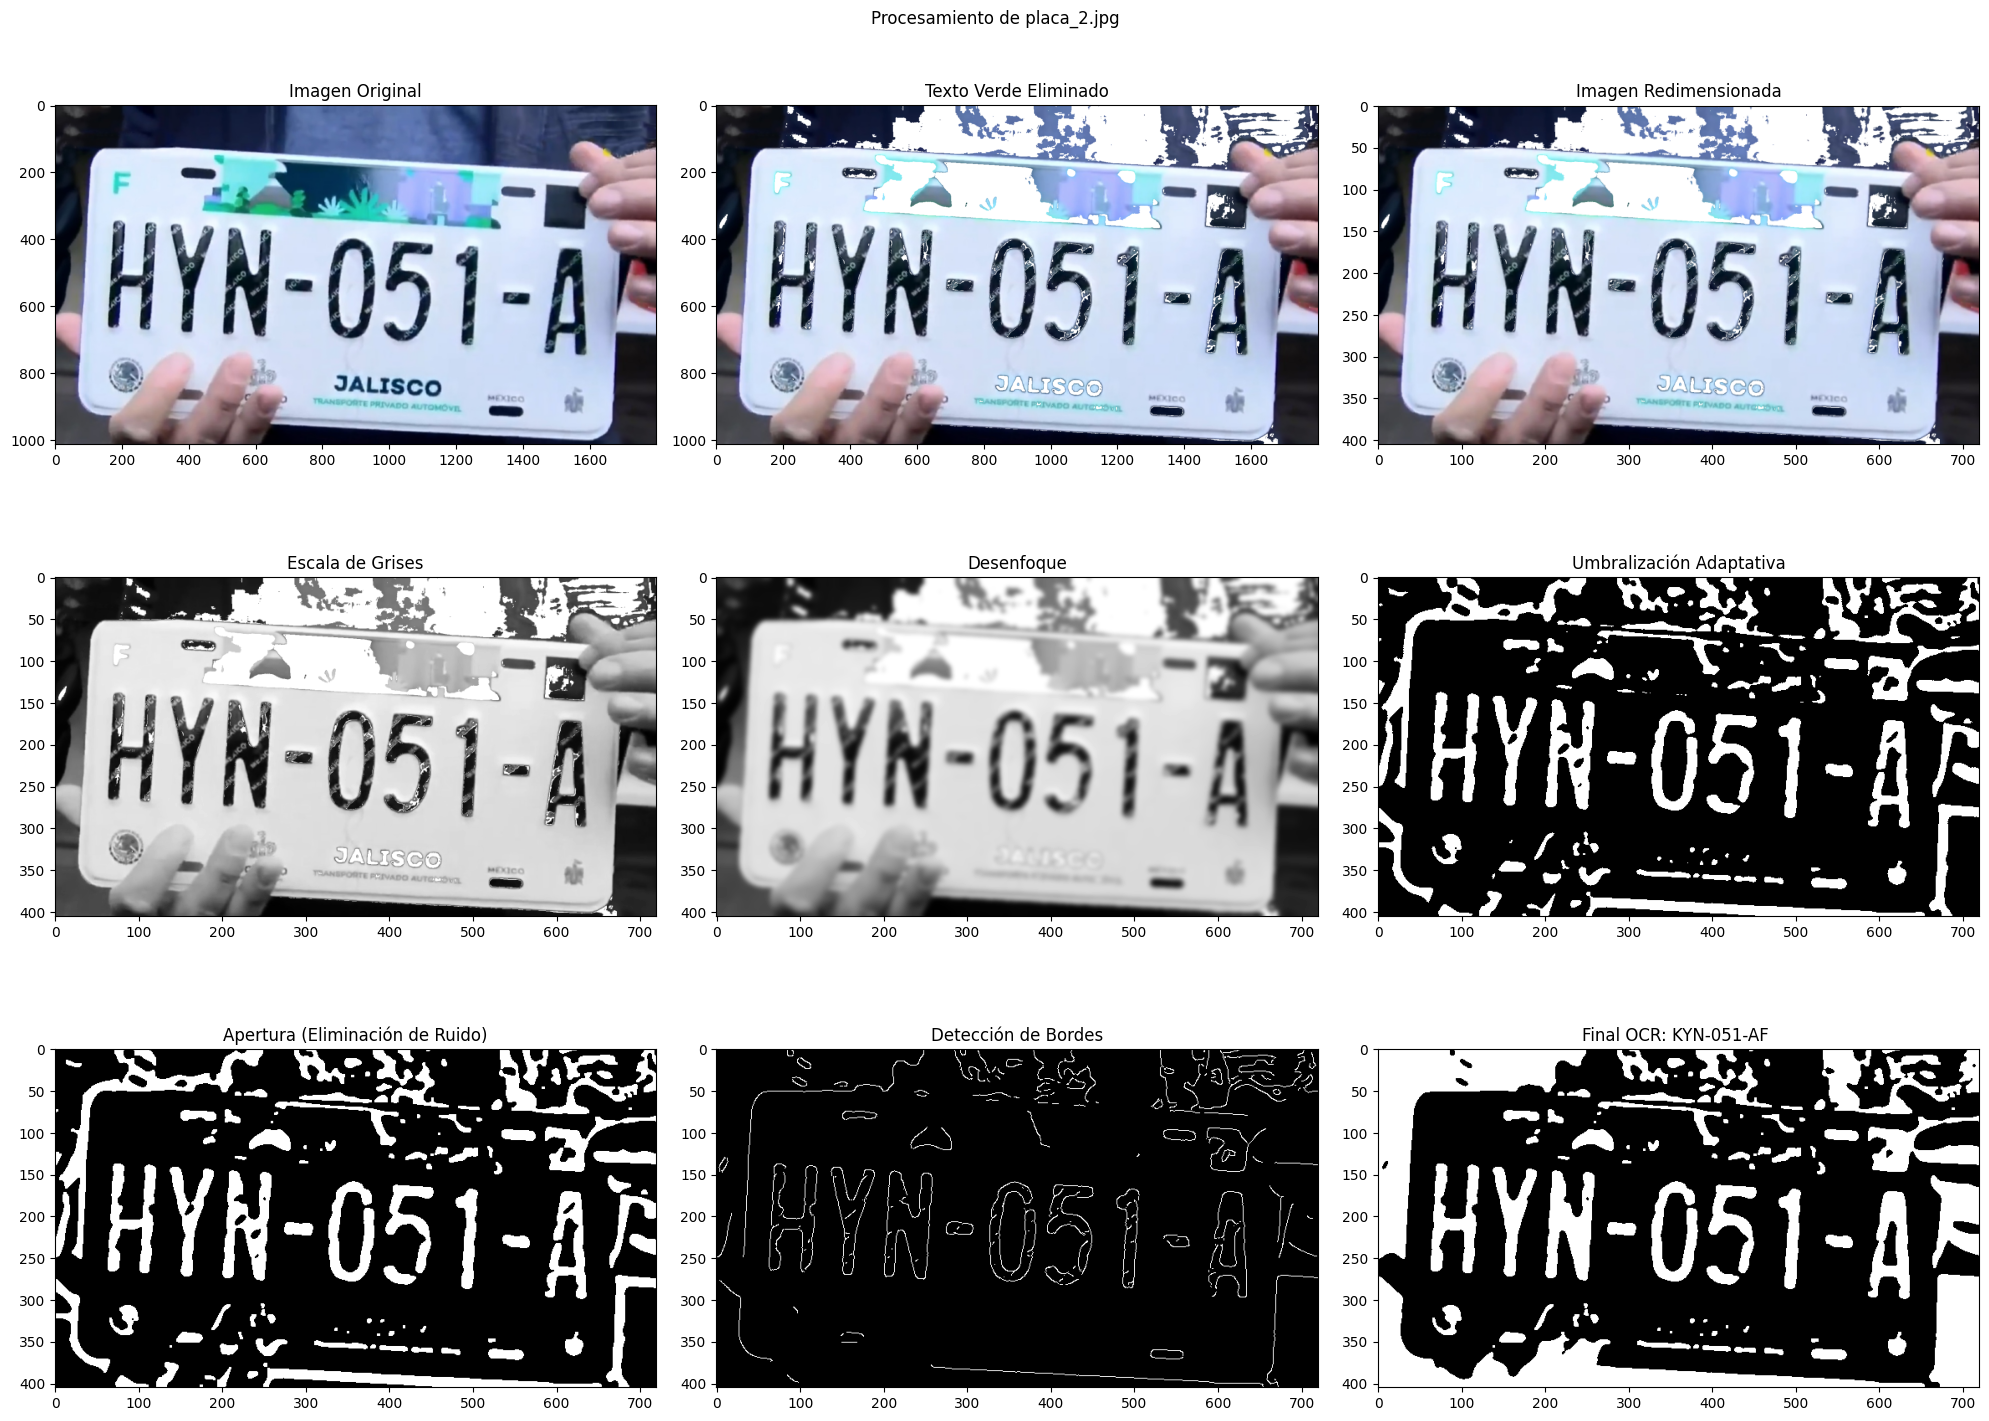

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Imagen: placa_q.jpg
Texto reconocido: JALISCO 
--------------------------------------------------
Imagen procesada guardada como 'processed_placa_q.jpg'


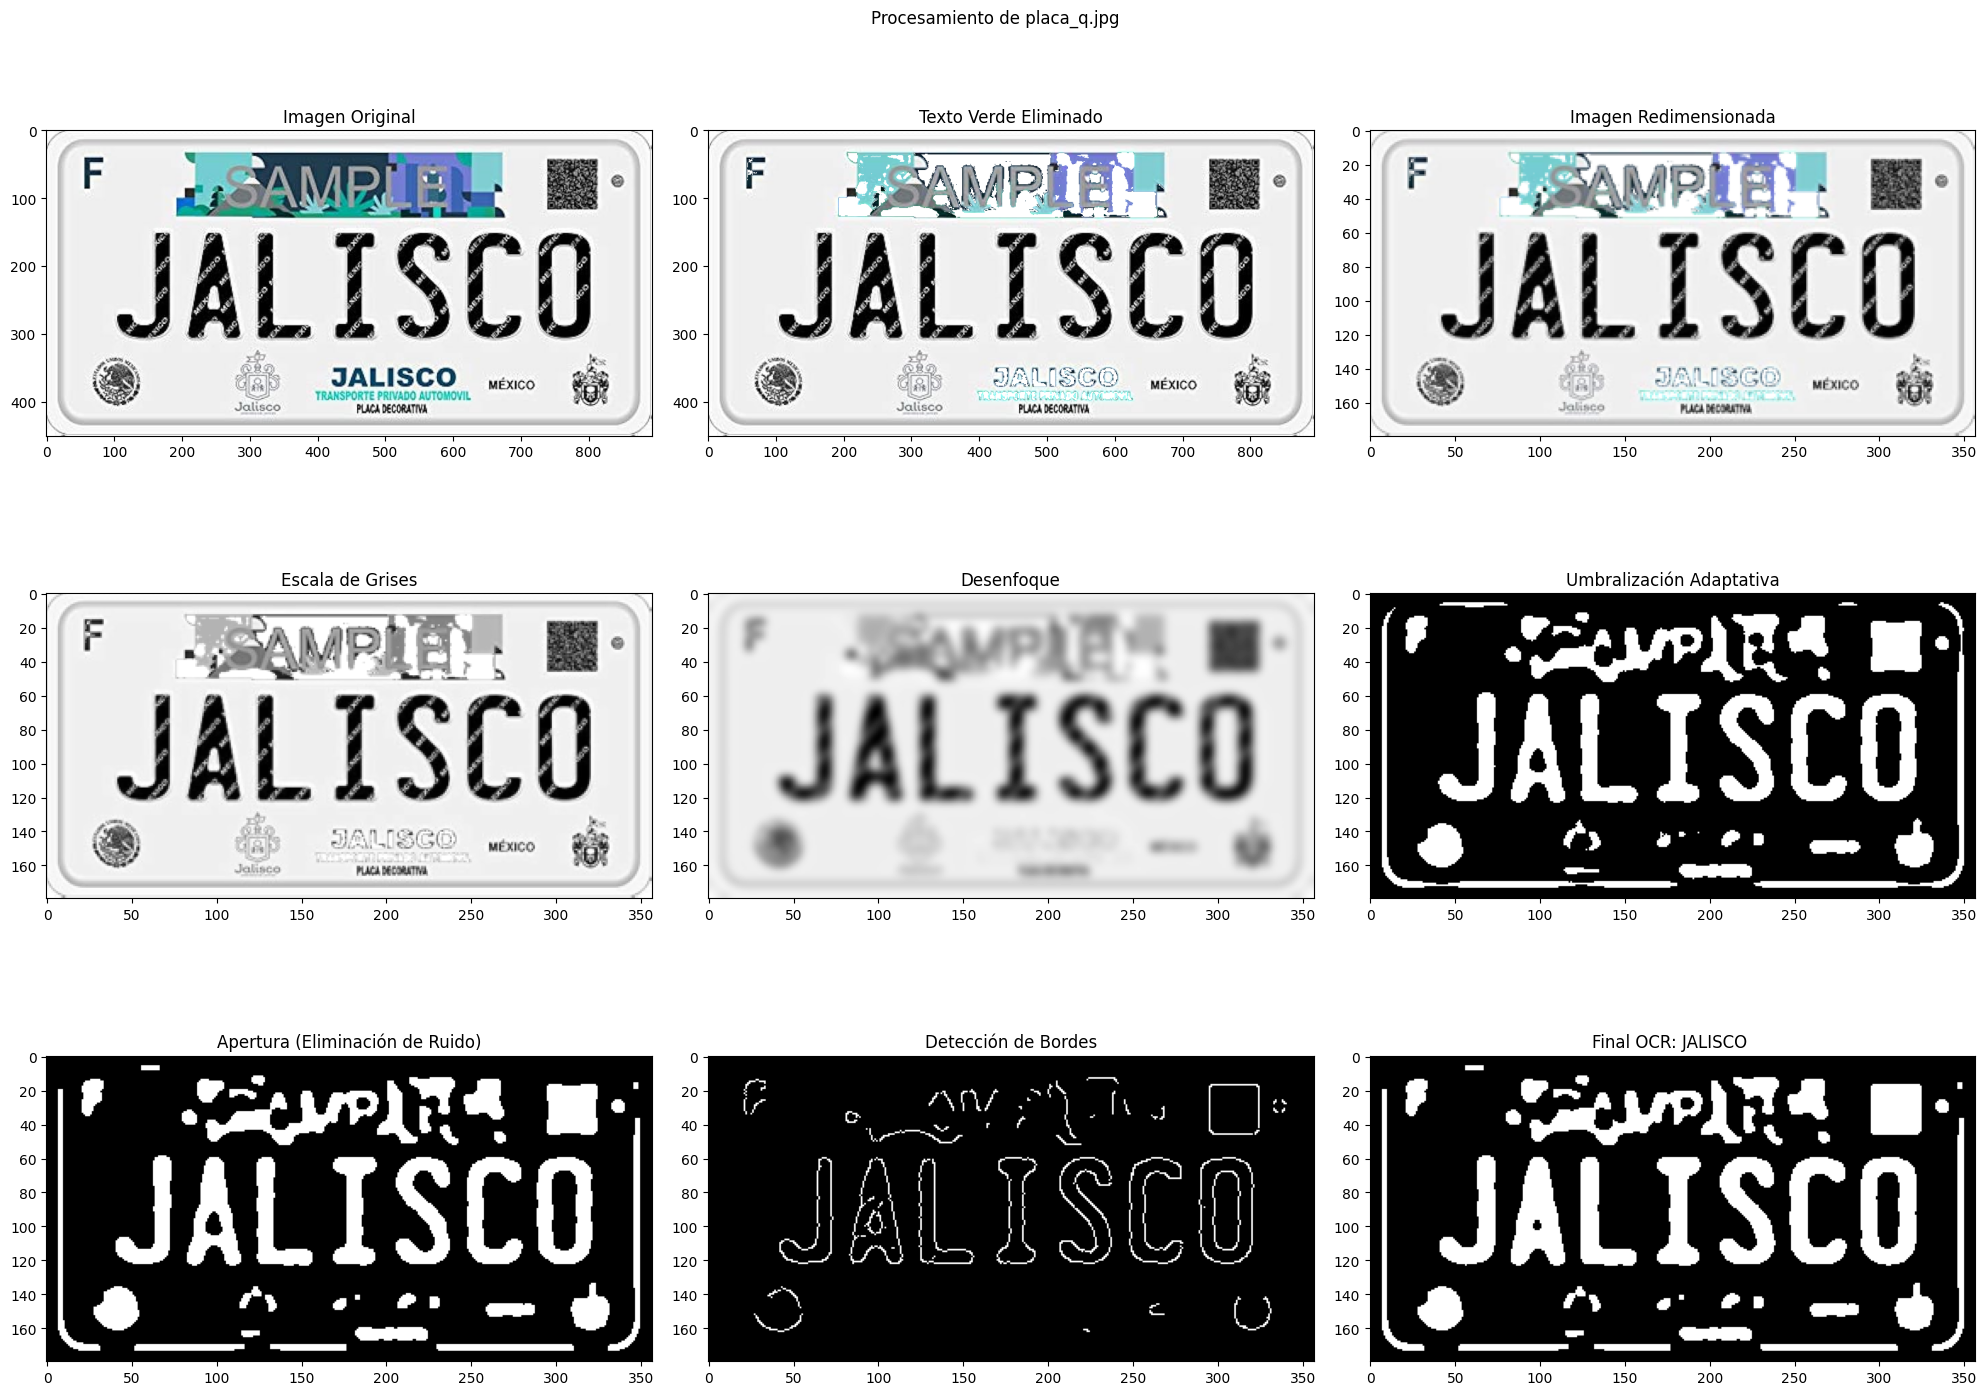

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Imagen: placa_3.jpg
Texto reconocido: Ja-60-261 
--------------------------------------------------
Imagen procesada guardada como 'processed_placa_3.jpg'


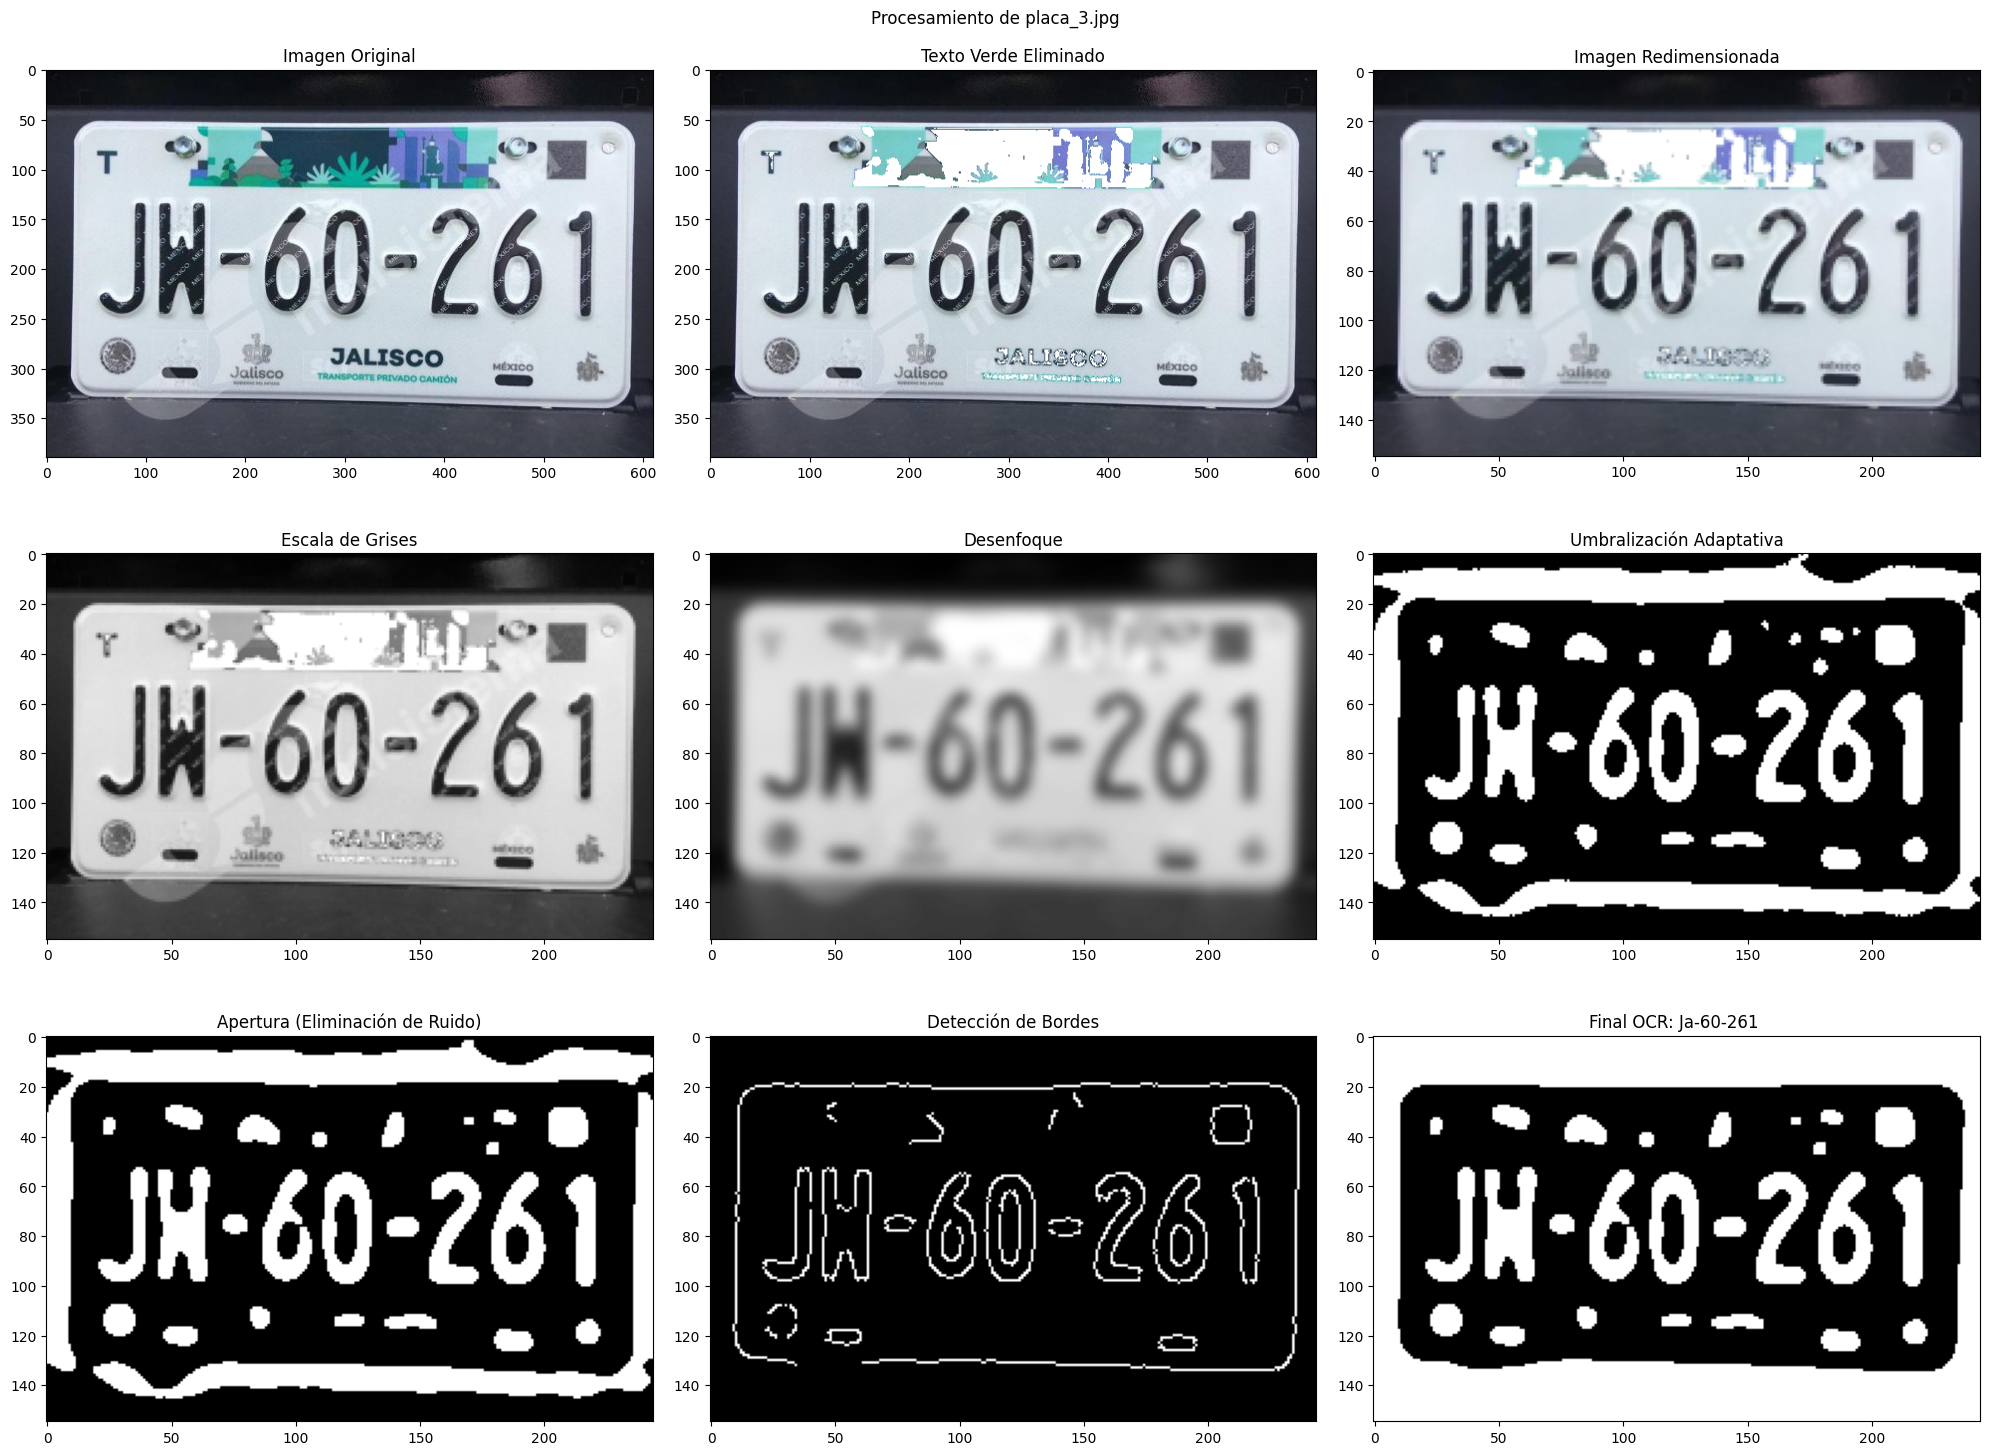

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Imagen: placa_4.jpg
Texto reconocido: TU: TEXTO 
--------------------------------------------------
Imagen procesada guardada como 'processed_placa_4.jpg'


In [ ]:


def remove_green_text(imagen):
	# convertir a espacio de color HSV
	hsv = cv2.cvtColor(imagen, cv2.COLOR_BGR2HSV)
	
	# definir rango de color verde para el texto "Jalisco"
	lower_green = np.array([35, 120, 60])
	upper_green = np.array([115, 255, 255])
	
	# crear máscara para el color verde
	mask = cv2.inRange(hsv, lower_green, upper_green)
	
	# reemplazar el texto verde con blanco
	imagen_copy = imagen.copy()
	imagen_copy[mask == 255] = [255, 255, 255]
	
	return imagen_copy

def process_image(imagen_path):
	# cargar imagen
	imagen = cv2.imread(imagen_path)
	if imagen is None:
		print(f"No se pudo cargar la imagen: {imagen_path}")
		return None
	
	# paso 0: eliminar texto "Jalisco" basado en color
	imagen_processed = remove_green_text(imagen)
	
	# cambiar color de BGR a RGB para mostrar
	imagen_rgb = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
	imagen_processed_rgb = cv2.cvtColor(imagen_processed, cv2.COLOR_BGR2RGB)
	
	# paso 1: redimensionar la imagen (reducir escala)
	height, width = imagen_processed.shape[:2]
	scale_factor = 0.4
	new_width = int(width * scale_factor)
	new_height = int(height * scale_factor)
	resized = cv2.resize(imagen_processed, (new_width, new_height), interpolation=cv2.INTER_AREA)
	resized_rgb = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
	
	# paso 2: convertir a escala de grises
	gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
	
	# paso 3: aplicar desenfoque gaussiano para reducir ruido
	blurred = cv2.GaussianBlur(gray, (15, 15), 0)
	
	# paso 4: aplicar umbralización adaptativa para mejor extracción de texto
	binary = cv2.adaptiveThreshold(
		blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
		cv2.THRESH_BINARY_INV, 45, 10
	)
	
	# paso 5: aplicar operaciones morfológicas para mejorar texto
	kernel = np.ones((3, 3), np.uint8)
	opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)
	
	# paso 6: detección de bordes para los límites de caracteres
	edges = cv2.Canny(blurred, 120, 130)
	
	# paso 7: crear imagen final en blanco y negro optimizada para OCR
	_, otsu_thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
	final_ocr_image = cv2.bitwise_or(opening, otsu_thresh)
	
	# usar easyocr para leer la placa
	reader = easyocr.Reader(['en'])
	results = reader.readtext(final_ocr_image)
	
	# extraer el texto reconocido
	recognized_text = ""
	for (bbox, text, prob) in results:
		recognized_text += text + " "
	
	# mostrar todos los pasos del procesamiento
	plt.figure(figsize=(20, 15))
	
	# mostrar imagen original
	plt.subplot(3, 3, 1)
	plt.imshow(imagen_rgb)
	plt.title("Imagen Original")
	
	# mostrar imagen con texto verde eliminado
	plt.subplot(3, 3, 2)
	plt.imshow(imagen_processed_rgb)
	plt.title("Texto Verde Eliminado")
	
	# mostrar imagen redimensionada
	plt.subplot(3, 3, 3)
	plt.imshow(resized_rgb)
	plt.title("Imagen Redimensionada")
	
	# mostrar escala de grises
	plt.subplot(3, 3, 4)
	plt.imshow(gray, cmap='gray')
	plt.title("Escala de Grises")
	
	# mostrar imagen desenfocada
	plt.subplot(3, 3, 5)
	plt.imshow(blurred, cmap='gray')
	plt.title("Desenfoque")
	
	# mostrar umbralización adaptativa
	plt.subplot(3, 3, 6)
	plt.imshow(binary, cmap='gray')
	plt.title("Umbralización Adaptativa")
	
	# mostrar apertura (eliminación de ruido)
	plt.subplot(3, 3, 7)
	plt.imshow(opening, cmap='gray')
	plt.title("Apertura (Eliminación de Ruido)")
	
	# mostrar detección de bordes
	plt.subplot(3, 3, 8)
	plt.imshow(edges, cmap='gray')
	plt.title("Detección de Bordes")
	
	# mostrar imagen final para OCR
	plt.subplot(3, 3, 9)
	plt.imshow(final_ocr_image, cmap='gray')
	plt.title(f"Final OCR: {recognized_text}")
	
	plt.suptitle(f"Procesamiento de {os.path.basename(imagen_path)}")
	plt.tight_layout()
	
	return final_ocr_image, recognized_text

# lista de todas las imágenes a procesar
image_paths = ["placa_2.jpg", "placa_q.jpg", "placa_3.jpg", "placa_4.jpg"]

# procesar cada imagen
for img_path in image_paths:
	result = process_image(img_path)
	if result:
		final_image, ocr_text = result
		print(f"Imagen: {img_path}")
		print(f"Texto reconocido: {ocr_text}")
		print("-" * 50)
		
		# guardar la imagen procesada
		output_path = f"processed_{os.path.basename(img_path)}"
		cv2.imwrite(output_path, final_image)
		print(f"Imagen procesada guardada como '{output_path}'")
		
		# mostrar el resultado actual antes de continuar con la siguiente imagen
		plt.show()